<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/dev-notebooks/15-close-to-end-to-end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Apr 28 18:46:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
repo_dir = '/content/'
style_gan_dir = repo_dir + 'stylegan2-ada-pytorch'

!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3
!wget -P {repo_dir} https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git {style_gan_dir}
!pip install facenet-pytorch
!pip install deepface
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/16070.jpg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-28 18:47:53--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 52.84.162.36, 52.84.162.31, 52.84.162.5, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|52.84.162.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘/content/ffhq.pkl.1’

ffhq.pkl.1          100%[===================>] 363.94M   170MB/s    in 2.1s    

2023-04-28 18:47:56 (170 MB/s) - ‘/content/ffhq.pkl.1’ saved [381624121/381624121]

fatal: destination path '/content/stylegan2-ada-pytorch' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

In [4]:
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/cropped_face.jpg content/

--2023-04-28 18:48:09--  https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/cropped_face.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2621 (2.6K) [image/jpeg]
Saving to: ‘cropped_face.jpg’

cropped_face.jpg    100%[===================>]   2.56K  --.-KB/s    in 0s      

2023-04-28 18:48:09 (48.1 MB/s) - ‘cropped_face.jpg’ saved [2621/2621]

--2023-04-28 18:48:09--  http://content/
Resolving content (content)... failed: Name or service not known.
wget: unable to resolve host address ‘content’
FINISHED --2023-04-28 18:48:09--
Total wall clock time: 0.2s
Downloaded: 1 files, 2.6K in 0s (48.1 MB/s)


In [5]:
import os
import cv2
import time
import math
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps
from deepface import DeepFace
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, repo_dir + 'stylegan2-ada-pytorch')
import dnnlib
import torch_utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

### Setting up plugins & downloading model weights for stylegan2-ada-pytorch & deepface ###

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)  # torch.nn.Module
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels

Image.fromarray(np.random.randint(0, high=255, size=(408, 612, 3), dtype=np.uint8)).save('dummy_image.jpg')
objs = DeepFace.analyze(img_path = 'dummy_image.jpg', actions = ['age', 'gender', 'race'], enforce_detection = False)

Directory  /root /.deepface created
Directory  /root /.deepface/weights created
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:08<00:00, 61.4MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:07<00:00, 73.5MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:08<00:00, 61.8MB/s]
Action: race: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


In [6]:
with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device) 
print(f"G parameters: {sum(p.numel() for p in G.parameters()):,} | D Parameters: {sum(p.numel() for p in D.parameters()):,}")

G parameters: 30,370,060 | D Parameters: 29,012,513


In [47]:
def tensor_to_np(img):
    """Torch tensor -> normalized np image"""
    torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True, padding = 0)
    return np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)

def display_and_concat(images,size = (500,500)):
    images_to_concat = []
    for image in images:
        images_to_concat.append(tensor_to_np(image))
    display_img = np.concatenate(images_to_concat,axis=1)
    display(ImageOps.contain(Image.fromarray(display_img), size))

def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    if all_boxes is None: return [], [], []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    # print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs

def find_best_zs(mtcnn, G, real_traits, max_iterations = 50, samples_wanted = 3, silent = True):
    best_zs = [] # [(age diff, z),...]
    for i in range(max_iterations):
        if len(best_zs) == samples_wanted:
            break
        z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
        img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
        torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True)
        np_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
        boxes, landmarks, probs = generate_boxes_landmarks(np_img, mtcnn, device)
        if len(boxes) == 0:
            # print("No faces found!! skip example")
            continue

        box_generated = boxes[0]
        display_img = np_img[box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]
        cv2.imwrite("temp.jpg", display_img)
        generated_traits = DeepFace.analyze(img_path = "temp.jpg", actions = ['age', 'gender', 'race'], enforce_detection = False, silent = silent)
        matching = True
        for key in ['dominant_gender', 'dominant_race']:
            if real_traits[key] != generated_traits[0][key]:
                # print(f"Not matching on: {key}")
                matching = False
                break

        if not matching: continue
        # display(ImageOps.contain(Image.fromarray(np_img), (400, 400)))

        age_diff = abs(real_traits['age'] - generated_traits[0]['age'])
        best_zs.append([age_diff, z, box_generated])
    # best_zs = sorted(best_zs, key=lambda x: x[0], reverse=False)
    print(f"[{len(best_zs)}/{samples_wanted}] generated in {i} iterations")
    return best_zs

def poisson_blend(paste_image, source_img, box):
    """ Poisson blending using seamlessClone
    blends paste_image into source_image
    """
    src_mask = np.zeros(paste_image.shape, paste_image.dtype)
    height,width = paste_image.shape[:2]

    rectangle = np.array([
        [0, 0], 
        [0, height],
        [width, height],
        [width, 0]], np.int32)
    cv2.fillPoly(src_mask, [rectangle], (255, 255, 255))

    box_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    blended = cv2.seamlessClone(paste_image, source_img, src_mask, box_centre, cv2.NORMAL_CLONE)
    return blended

def create_training_masks_targets(best_zs, real_face):
    tensor_transform = transforms.ToTensor()
    training_images = []
    for _, z, box in best_zs: 
        #Generate image
        img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
        np_generated = tensor_to_np(img)
        # display(ImageOps.contain(Image.fromarray(np_generated), (400, 400)))

        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        #Create a mask of the cropped image's border
        border_width = int(width*border_factor)
        border_height = int(height*border_factor)
        mask = torch.zeros((1, 3, 1024, 1024)).to(device)
        mask[:, :, y1:y2, x1:x2] = 1
        mask[:, :, y1+border_height:y2-border_height, x1+border_width:x2-border_width] = 0
        
        # resize original face to generated face's size
        resized_face = cv2.resize(real_face.copy(), [width, height])

        #convert image to torch tensor, place face aligned in 1024x1024 square
        real_face_tensor = torch.zeros((1, 3, 1024, 1024)).to(device)
        real_face_tensor[:, :, y1:y2, x1:x2] = tensor_transform(resized_face).unsqueeze(dim=0).to(device)
        training_images.append([z, box, real_face_tensor, mask])
        
    return training_images

def train_loop(training_images, track_progress = 50, eval_interval = 50,  iterations = 800):
    """
    Set track_progress/eval_interval to 0 to not record/display
    """
    zs = [array[0] for array in training_images]
    fixed_noise = torch.cat(zs, dim=0).clone().requires_grad_(True) #512 input latent vector

    lr = 0.003
    lam = 0.0005 # perceptual_loss factor
    
    progress = []

    # criterion = nn.BCELoss()
    optimizer = optim.Adam([fixed_noise], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

    t_start = time.time()
    for i in range(iterations):
        fake_faces = G(fixed_noise, None)
        perceptual_loss = torch.sum(D(fake_faces, None).view(-1))# unbounded, the more negative, the more confident D is that it's real
        
        contextual_losses = []
        for face_idx, (_, _, real_face_tensor, mask) in enumerate(training_images):
            fake_face = fake_faces[face_idx].unsqueeze(dim=0)
            contextual_loss_singular = nn.functional.l1_loss(real_face_tensor*mask, fake_face*mask)
            contextual_losses.append(contextual_loss_singular)
        contextual_loss = sum(contextual_losses)
        
        complete_loss = contextual_loss + lam*perceptual_loss

        optimizer.zero_grad()
        complete_loss.backward()
        optimizer.step()
        scheduler.step()

        if eval_interval != 0 and i % eval_interval == 0:
            print(f"Losses, {i} iteration:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f},  perceptual original: {perceptual_loss:.4f}, perceptual (after x{lam}): {lam*perceptual_loss:.4f} ,, time: {time.time()-t_start:.2f}s")
        if track_progress != 0 and i % track_progress == 0:
            progress.append(fake_faces.clone().cpu())   

    print(f"Generation finished for {len(training_images)} in {time.time()-t_start:.2f} seconds")
    return fake_faces, fixed_noise, progress


def calculate_rotate_angle(left_eye, right_eye):

    if left_eye[1] > right_eye[1]: # right eye higher than left eye
        # print("rotating clockwise")
        direction = -1
        third_point = (right_eye[0], left_eye[1])
    else:
        # print("rotating counter-clockwise")
        direction = 1
        third_point = (left_eye[0], right_eye[1])

    def euclidean_distance(a, b):
        return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    a = euclidean_distance(left_eye, third_point)
    b = euclidean_distance(right_eye, left_eye)
    c = euclidean_distance(right_eye, third_point)
    angle = np.degrees(np.arccos((b*b + c*c - a*a)/(2*b*c)))

    if direction == -1:
        angle = 90 - angle

    rotate_angle = direction * angle
    return rotate_angle

def find_new_bbox_cords(mtcnn, rotated_img, face_centre):
    new_boxes, new_landmarks, new_probs = generate_boxes_landmarks(rotated_img, mtcnn, device)
    boxes_distances = []
    for new_box, new_landmark in zip(new_boxes, new_landmarks):
        centre = [(new_box[0] + new_box[2])//2, (new_box[1] + new_box[3])//2]
        difference = abs(np.array(centre) - np.array(face_centre)).mean()
        boxes_distances.append([difference, new_box])
    if len(boxes_distances) == 0: 
        return []
    boxes_distances.sort(key=lambda x: x[0])
    wanted_box = boxes_distances[0][1]
    return wanted_box

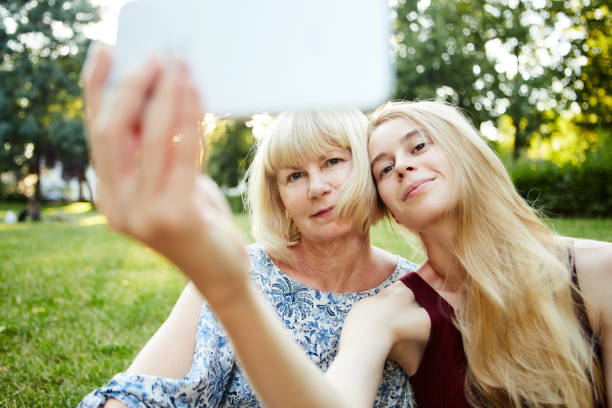

In [49]:
image_filepath = '16070.jpg'

# Load MTCNN face detection model
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

#  Load image using cv2
original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# original_img = original_img[:, ::-1].copy()
pad_width = max(original_img.shape[:2])//2

#finds boxes, landmarks using original image
raw_boxes, raw_landmarks, probs = generate_boxes_landmarks(original_img, mtcnn, device)
boxes = [[x+pad_width for x in box] for box in raw_boxes]
landmarks = [[[point[0]+pad_width, point[1]+pad_width] for point in landmark] for landmark in raw_landmarks]

display(Image.fromarray(original_img))

In [76]:
print("Starting main loop:")
cropped_faces = []
for box, landmark in zip(boxes, landmarks):
    left_eye, right_eye = landmark[0], landmark[1]
    face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]

    # work with padded image to ensure during rotation the face does not leave the image
    original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
    original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()

    rotate_angle = calculate_rotate_angle(left_eye, right_eye)
    rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
    rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre)

    cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()
    cropped_faces.append([cropped_face, box, rotated_box, rotated_img, rotate_angle, face_centre])

Starting main loop:


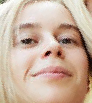

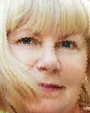

In [85]:
#Inpaint faces
generated_faces = [array[0][:, ::-1].copy() for array in cropped_faces]
for face in generated_faces:
    display(Image.fromarray(face))

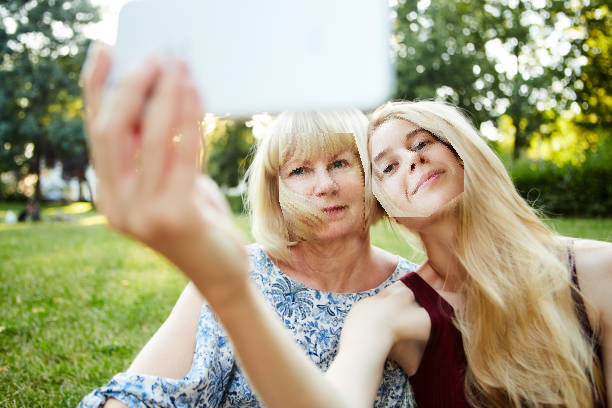

In [87]:
output_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
output_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()

for generated_face, (_, box, rotated_box, rotated_img, rotate_angle, face_centre) in zip(generated_faces, cropped_faces):
    #place generated image on rotated image
    rotated_img = rotated_img.copy()
    rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = generated_face
    #rotate back to original alignment
    rotated_img = np.array(Image.fromarray(rotated_img).rotate(-rotate_angle, center=face_centre, expand=False))

    #place generated poisson blended, rotated face back onto original image
    output_img_padded[box[1]:box[3], box[0]:box[2]] = rotated_img[box[1]:box[3], box[0]:box[2]]


output_img = output_img_padded[pad_width:-pad_width, pad_width:-pad_width]
display(Image.fromarray(output_img))

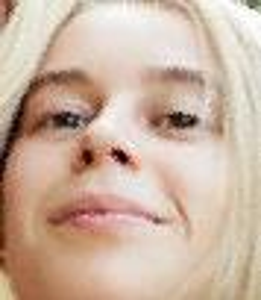

[3/3] generated in 20 iterations


In [ ]:


border_factor = 0.15
real_traits = {'age': 29,
               'dominant_gender': 'Woman',
               'dominant_race' : 'white'}
### Real_face inputted as parameter to mode, as well as border_factor
# Deepface seems awful on the face I tested out, maybe it's better on others
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model


display(ImageOps.contain(Image.fromarray(real_face), (300, 300)))

best_zs = find_best_zs(mtcnn, G, real_traits, max_iterations = 50, samples_wanted = 3)
best_zs = best_zs[:2] # DELETE

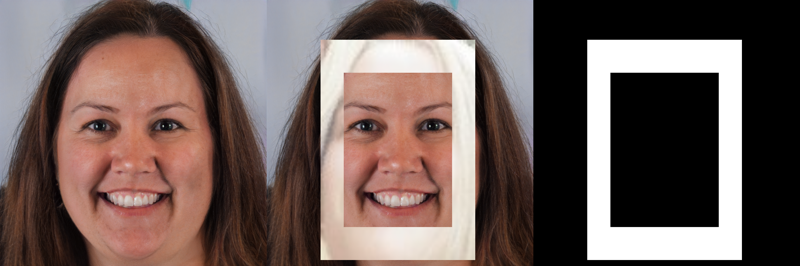

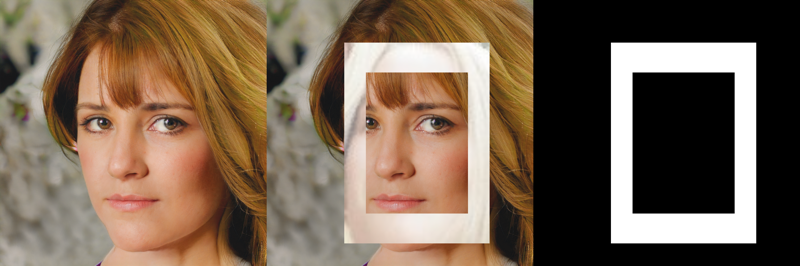

In [ ]:
training_images = create_training_masks_targets(best_zs, real_face)
for z, box, real_face_tensor, mask in training_images:
    img = G(z, None) 
    display_and_concat([img, real_face_tensor*mask + img*(1-mask), mask], size = (800, 800))

In [ ]:
torch.cuda.empty_cache()
fake_faces, fixed_noise, progress = train_loop(training_images, track_progress = 50, eval_interval = 200)

Losses, 0 iteration:: Complete:0.4245, contextual:0.4278,  perceptual original: -6.5984, perceptual (after x0.0005): -0.0033 ,, time: 0.10s
Losses, 200 iteration:: Complete:0.0445, contextual:0.0480,  perceptual original: -6.9823, perceptual (after x0.0005): -0.0035 ,, time: 14.24s
Losses, 400 iteration:: Complete:0.0395, contextual:0.0437,  perceptual original: -8.4084, perceptual (after x0.0005): -0.0042 ,, time: 28.37s
Losses, 600 iteration:: Complete:0.0377, contextual:0.0421,  perceptual original: -8.7938, perceptual (after x0.0005): -0.0044 ,, time: 42.50s
Generation finished for 2 in 56.71 seconds


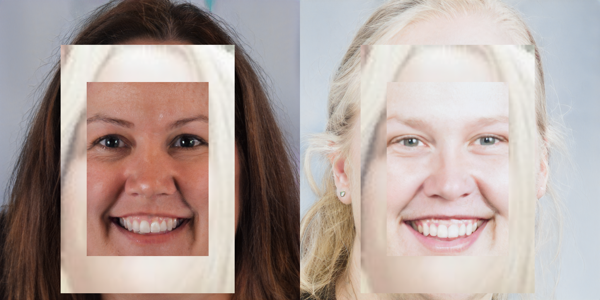

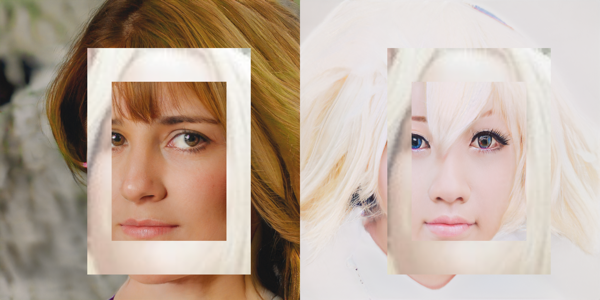

In [ ]:
for i, (z, box, real_face_tensor, mask) in enumerate(training_images):
    img = G(z, None) 
    generated_face = fake_faces[i].unsqueeze(dim=0)
    display_and_concat([real_face_tensor*mask + img*(1-mask), real_face_tensor*mask + generated_face*(1-mask)], size = (600, 600))


Original Face -> Random generated -> Inpainting -> Poisson Blended


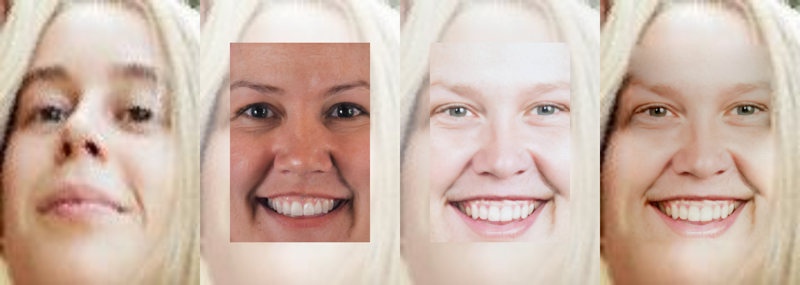

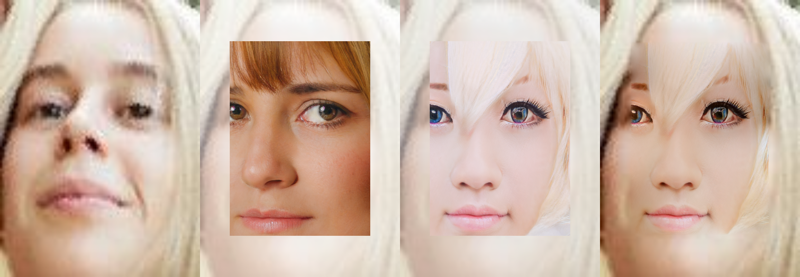

In [ ]:
print("Original Face -> Random generated -> Inpainting -> Poisson Blended")
for z_idx, (z, box, real_face_tensor, mask) in enumerate(training_images):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    #Create a mask of the cropped image's border
    border_width = int(width*border_factor)
    border_height = int(height*border_factor)

    # resize original face to generated face's size
    resized_face = cv2.resize(real_face, [width, height])
    centre_box = [0, 0, resized_face.shape[1], resized_face.shape[0]]

    generated_face = fake_faces[z_idx].unsqueeze(dim=0)
    np_generated = tensor_to_np(generated_face)
    paste_image = np_generated[y1+border_height:y2-border_height, x1+border_width:x2-border_width]
    blended = poisson_blend(paste_image, resized_face, centre_box)

    original_generated = G(z, None) 
    original_masked_img = tensor_to_np(real_face_tensor*mask + original_generated*(1-mask))[y1:y2, x1:x2]
    raw_masked_img = tensor_to_np(real_face_tensor*mask + generated_face*(1-mask))[y1:y2, x1:x2]
    
    display_img = np.concatenate([resized_face, original_masked_img, raw_masked_img, blended],axis=1)
    display(ImageOps.contain(Image.fromarray(display_img), (800, 800)))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
all_images_to_animate = []
for z_idx, (_, z, box) in enumerate(best_zs[:1]):

    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1
    #Create a mask of the cropped image's border
    border_width = int(width*border_factor)
    border_height = int(height*border_factor)

    # resize original face to generated face's size
    resized_face = cv2.resize(real_face, [width, height])
    centre_box = [0, 0, resized_face.shape[1], resized_face.shape[0]]
    
    #Generate image
    images_to_animate_face = []
    for i in range(len(progress)):
        img=progress[i][z_idx]
        np_generated = tensor_to_np(img)
        paste_image = np_generated[y1+border_height:y2-border_height, x1+border_width:x2-border_width]
        blended = poisson_blend(paste_image, resized_face, centre_box)
        images_to_animate_face.append(blended)
    all_images_to_animate.append(images_to_animate_face)

#animation plots to create: 1


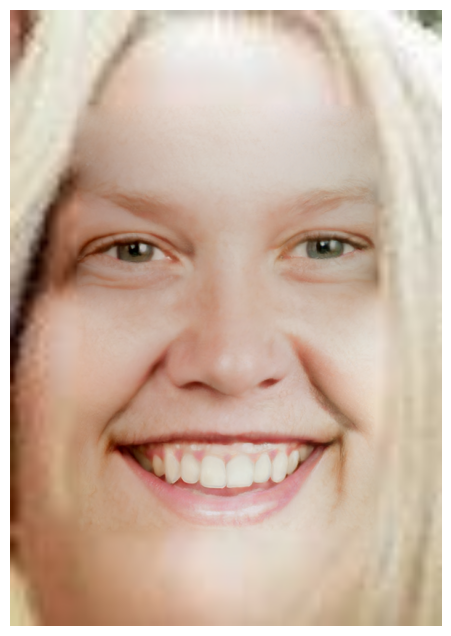

In [ ]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

print("#animation plots to create:", len(all_images_to_animate))
fig = plt.figure(figsize=(8,8))
plt.axis("off")

images_to_animate = all_images_to_animate[0]
ims = [[plt.imshow(face_image)] for face_image in images_to_animate]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)
video_animation = HTML(ani.to_html5_video())

In [ ]:
video_animation